In [1]:
import sys
sys.path.append('..')
from dhg import Hypergraph
from hypgs.models.hsn_pyg import HSN
from hypgs.utils.data import HGDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import random_split
from pytorch_lightning.loggers import TensorBoardLogger
from hypgs import DATA_DIR
import anndata
import os
import torch
import numpy as np
import phate
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
import random 


In [2]:
data_path = os.path.join(DATA_DIR, 'spatial_data', 'A23-290-CP_anndata.h5ad')
cell_data = anndata.read_h5ad(data_path)
print(cell_data)

AnnData object with n_obs × n_vars = 21331 × 16662
    obsm: 'X_spatial', 'spatial'


In [3]:
print(cell_data.var_names)
# CD45 is an immune gene marker
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']

# This will give you a vector/array of CD45 expression values for all observations
print(cd45_expression)

Index(['HNRNPA3P13', 'CDH13', 'MS4A18', 'LINC01515', 'LARP4B-DT', 'RPS3AP51',
       'FBXW8', 'PPIAP7', 'DUSP5-DT', 'SLC6A9',
       ...
       'RPSAP61', 'PAX3', 'TDRD12', 'WHAMMP2', 'DNAH17-AS1', 'LINC01276',
       'BIK', 'KCNQ5', 'RPL12P17', 'IL33'],
      dtype='object', length=16662)
View of AnnData object with n_obs × n_vars = 21331 × 1
    obsm: 'X_spatial', 'spatial'


In [4]:
cd45_expression.X

<21331x1 sparse matrix of type '<class 'numpy.float32'>'
	with 43 stored elements in Compressed Sparse Row format>

In [5]:
print(np.all(cell_data.obsm['X_spatial'] == cell_data.obsm['spatial']))
print(cell_data.obsm['spatial'].shape)


True
(21331, 2)


In [6]:
print(cell_data.X.shape)
print(type(cell_data.X))

(21331, 16662)
<class 'scipy.sparse._csr.csr_matrix'>


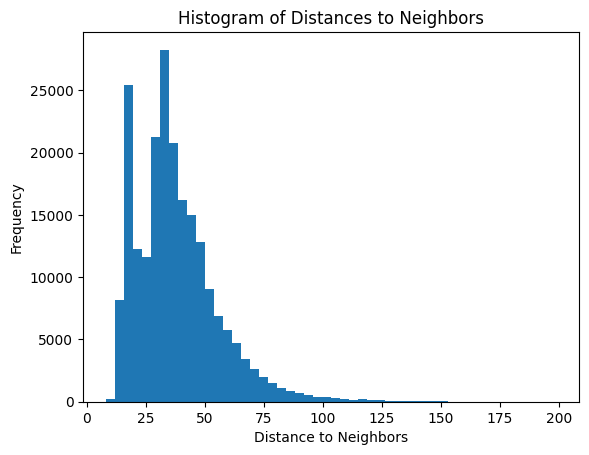

In [7]:
# Assuming 'X_spatial_data' is the actual 2D spatial data
X_spatial_data = cell_data.obsm['X_spatial']

# Construct KNN graph
n_neighbors = 10  # Number of neighbors for KNN
nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')  # Add 1 to exclude self-loops
nn.fit(X_spatial_data)
distances, indices = nn.kneighbors(X_spatial_data)

# Exclude self-loops (the first neighbor is the point itself)
indices = indices[:, 1:]
distances = distances[:, 1:]

# Flatten distances for histogram
distances = distances.flatten()

# Plot histogram of distances
plt.hist(distances, bins=50)
plt.xlabel('Distance to Neighbors')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Neighbors')
plt.show()


In [8]:
# Define epsilon
epsilon = 30  # decide this based off the histogram

# Find pairs of points within epsilon distance
dist_matrix = euclidean_distances(X_spatial_data)
adj_matrix = (dist_matrix < epsilon).astype(int)

np.fill_diagonal(adj_matrix, 0)  # Ensure no self-loops

# Construct graph based on adjacency matrix
graph = nx.from_numpy_array(adj_matrix)

# nx.draw(graph, pos=X_spatial_data, node_size=10)
# plt.show()



In [9]:
# Assuming 'cell_data' is your AnnData object with sparse matrix 'X'
X_sparse = cell_data.X  # Extract the sparse matrix

# Convert the sparse matrix to a dense matrix
X_dense = X_sparse.toarray()

# Run PHATE on the dense matrix
phate_operator = phate.PHATE(n_components=10)
phate_result = phate_operator.fit_transform(X_dense)

# 'phate_result' now contains the PHATE embedding of your data
print(phate_result.shape)  # Shape of the resulting embedding

Calculating PHATE...
  Running PHATE on 21331 observations and 16662 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 57.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 69.66 seconds.
    Calculating affinities...
    Calculated affinities in 11.59 seconds.
  Calculated graph and diffusion operator in 138.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.87 seconds.
  Calculated landmark operator in 10.34 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 3.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.86 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 199.01 seconds.
Calculated PHATE in 352.85 seconds.
(21331, 10)


In [10]:
K=10
sparseA = kneighbors_graph(cell_data.obsm['spatial'], K, mode='connectivity', include_self=False)
A = sparseA.todense()
G = nx.from_numpy_array(A)

In [9]:
from torch_geometric.utils.convert import from_networkx
data = from_networkx(G)
data.x = torch.tensor(phate_result)
original_dataset = [data]
to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, 1)
dataset = HGDataset(original_dataset, to_hg_func)

NameError: name 'G' is not defined

In [ ]:
from importlib import reload
from hypgs.models.hsn_pyg import HSN
import hypgs
# Reload the module
#reload(hypgs.models.hsn_pyg)

# Now re-import the class
from hypgs.models.hsn_pyg import HSN

In [13]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 1, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

In [21]:
node_feat, edge_feat = model(dataset[0].x.float(), dataset[0].edge_index, hyperedge_attr = dataset[0].edge_attr)

In [32]:
edge_feat

tensor([[-0.1555],
        [-0.5940],
        [-0.1192],
        ...,
        [ 0.9134],
        [-0.0801],
        [-0.4296]], grad_fn=<AddmmBackward0>)

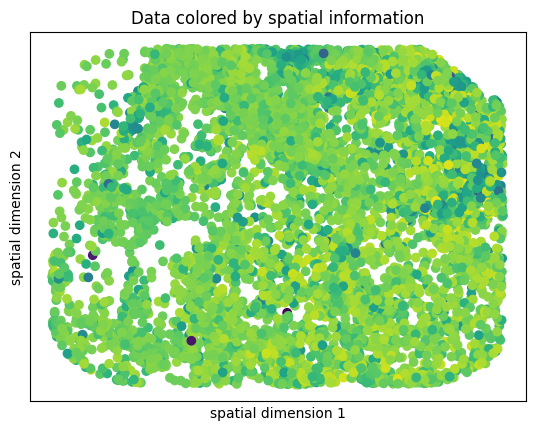

In [22]:
n_points = 8000

plt.scatter(cell_data.obsm['spatial'][:,0][:n_points], 
            cell_data.obsm['spatial'][:,1][:n_points], 
            c = node_feat[:n_points].detach().numpy())
plt.xlabel('spatial dimension 1')
plt.ylabel('spatial dimension 2')
plt.xticks([])
plt.yticks([])
plt.title('Data colored by full gene information')
plt.show()

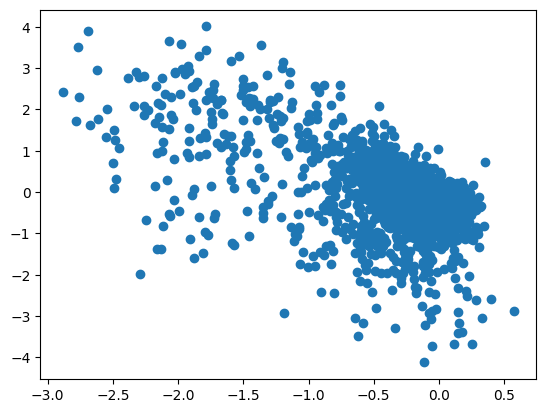

In [63]:
n_points = 6000
plt.scatter(edge_feat[:,0][:n_points].detach().numpy(), edge_feat[:,1][:n_points].detach().numpy())
plt.show()

In [24]:
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']
node_features = cd45_expression.X.toarray()

print(node_features.shape)

(21331, 1)


In [10]:
def get_hyperedge_reps(model, cell_data, features='full_seq_phate'):
    K=10
    sparseA = kneighbors_graph(cell_data.obsm['spatial'], K, mode='connectivity', include_self=False)
    A = sparseA.todense()
    G = nx.from_numpy_array(A)

    if features == 'full_seq_phate':
        X_sparse = cell_data.X  # Extract the sparse matrix
        # Convert the sparse matrix to a dense matrix
        X_dense = X_sparse.toarray()
        # Run PHATE on the dense matrix
        phate_operator = phate.PHATE(n_components=10)
        phate_result = phate_operator.fit_transform(X_dense)
        node_features = phate_result
    elif features == 'cd45':
        cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']
        node_features = cd45_expression.X.toarray()
    elif features == 'rand_dirac':
        n_feat = 10
        n_cells = cell_data.X.shape[0]
        n = 100  # Change this value to the number of 1s you want in each column
        node_features = torch.zeros(n_cells, n_feat)

        for j in range(n_feat):
            indices = random.sample(range(n_cells), n)
            for index in indices:
                node_features[index][j] = 1

    data = from_networkx(G)
    data.x = torch.tensor(node_features)
    original_dataset = [data]
    to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, 1)
    dataset = HGDataset(original_dataset, to_hg_func)

    node_feat, edge_feat = model(dataset[0].x.float(), dataset[0].edge_index, hyperedge_attr = dataset[0].edge_attr)

    edge_feat_phate_op = phate.PHATE()
    edge_phate = edge_feat_phate_op.fit_transform(edge_feat.detach().numpy())

    n_points = 8000
    plt.scatter(edge_phate[:, 0][:n_points], edge_phate[:,1][:n_points])
    plt.title(f"hyperedge representations from {features}")
    plt.xlabel('PHATE 1')
    plt.ylabel('PHATE 2')
    plt.xticks([])
    plt.yticks([])
    plt.show()


    


Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 2.60 seconds.
    Calculating affinities...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 205607 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 683.77 seconds.
  Calculated graph and diffusion operator in 695.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 149.01 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.84 seconds.
  Calculated landmark operator in 162.89 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.31 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.44 seconds.
Calculated PHATE in 858.82 seconds.


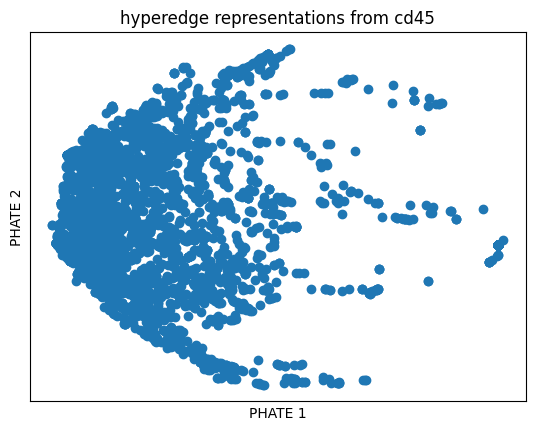

In [15]:
model = HSN(in_channels=1, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='cd45')

Calculating PHATE...
  Running PHATE on 21331 observations and 16662 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 15.35 seconds.
    Calculating KNN search...
    Calculated KNN search in 66.82 seconds.
    Calculating affinities...
    Calculated affinities in 10.06 seconds.
  Calculated graph and diffusion operator in 92.28 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.09 seconds.
  Calculated landmark operator in 8.43 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 3.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.19 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 199.02 seconds.
Calculated PHATE in 304.55 seconds.
Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 4.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.57 seconds.
  Calculated landmark operator in 8.11 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 3.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.18 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.70 seconds.
Calculated PHATE in 22.79 seconds.


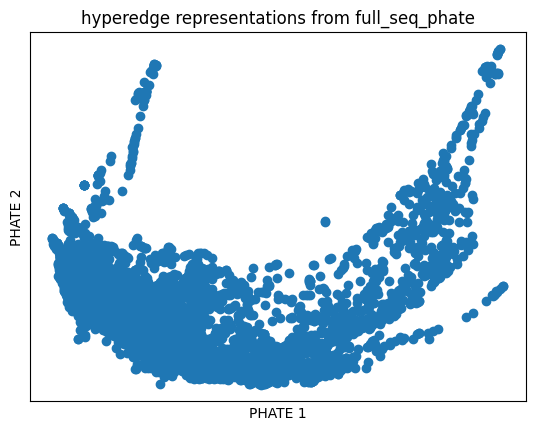

In [11]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='full_seq_phate')

/tmp/ipykernel_2240861/2978064971.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.x = torch.tensor(node_features)


Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.98 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 7.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.62 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.98 seconds.
  Calculated landmark operator in 7.55 seconds.
  Calculating optimal t...
    Automatically selected t = 46
  Calculated optimal t in 3.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.58 seconds.
Calculated PHATE in 24.31 seconds.


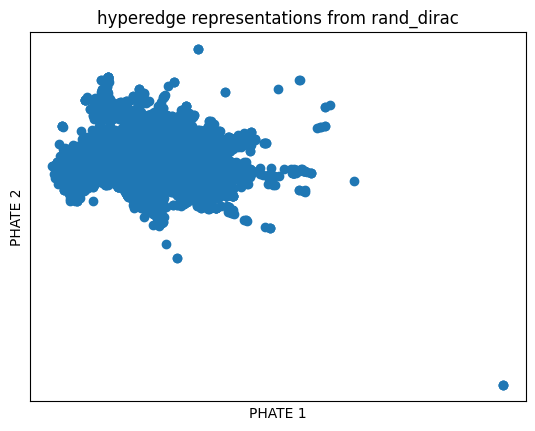

In [12]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='rand_dirac')

In [ ]:
# scatter immune information 
print(cell_data.var_names)
# CD45 is an immune gene marker
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']


# This will give you a vector/array of CD45 expression values for all observations
print(cd45_expression)

In [39]:
# Early stopping callback based on validation loss
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
logger = TensorBoardLogger("lightning_logs", name="my_model")

trainer = pl.Trainer(
    max_epochs=100,  # Adjust as necessary
    logger=logger,
    callbacks=[early_stopping_callback]
)

# Assuming you have defined train_loader and val_loader
trainer.fit(model, train_loader, val_loader)  # Corrected argument names
# Test the model
trainer.test(model, test_loader)

/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NameError: name 'train_loader' is not defined

In [48]:
n_feat = 4
n_cells = 10
n = 3  # Change this value to the number of 1s you want in each column
node_features = torch.zeros(n_cells, n_feat)

for j in range(n_feat):
    indices = random.sample(range(n_cells), n)
    for index in indices:
        node_features[index][j] = 1

print(node_features)

tensor([[0., 0., 0., 1.],
        [0., 1., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]])


In [46]:
node_features

tensor([[0., 1., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [0., 1., 1., 1.],
        [1., 1., 0., 1.]])